In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-sys-1-1-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


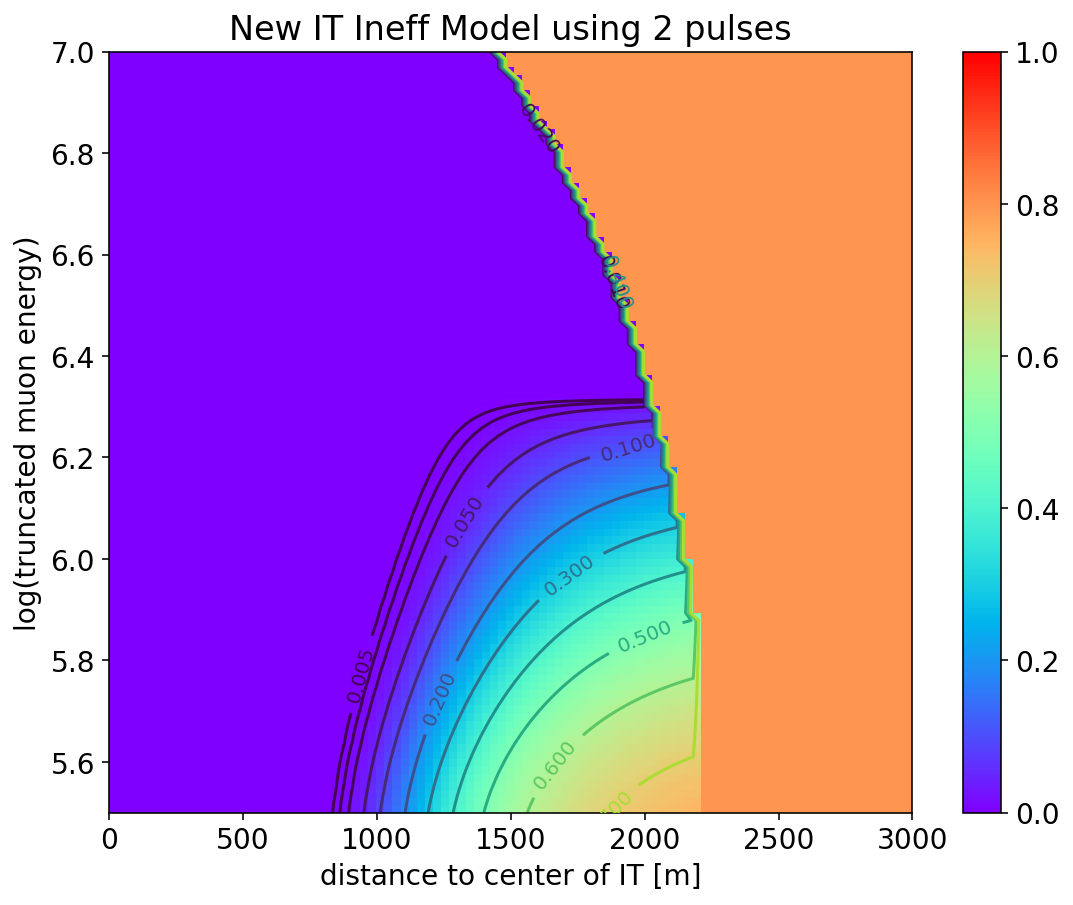

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]
    
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))
    val = a * np.exp(-b/(dist/2000)**(4.7))

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19017
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    ineff_numu = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))[CUT]
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.MCPrimary_new.cols.energy[:][CUT]
    zenith_truth_numu = f.root.MCPrimary_new.cols.zenith[:][CUT]

    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    runid_numu = f.root.FileNumber.cols.value[:][CUT]
    eventid_numu = f.root.FileNumber.cols.Event[:][CUT]  

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [6]:
with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity

    ineff_data_burn = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))[CUT]

    chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_new_data_burn = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_data_burn = f.root.Collection.cols.PeakOverMean[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)
    stoch_new_data_burn = np.log10(chi2_red_new_data_burn)/8 + np.log10(PeakOverMedian_data_burn)
    
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_data_burn = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_data_burn = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_data_burn = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_data_burn = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_data_burn = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_data_burn = f.root.CVMultiplicity.cols.n_pulses[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
#     weight_data_burn = np.sum(weight_corsika)/np.sum(np.ones_like(zenith_data_burn)) * np.ones_like(zenith_data_burn)


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [7]:
def sumw2(b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

In [57]:
totalbins = 15 # 30. bins in each dimension of global optimization
ineffbins = np.linspace(0.005,0.205,totalbins)
chi2bins = np.linspace(2.25,3.,totalbins)
print(chi2bins[1]-chi2bins[0])
print(ineffbins[1]-ineffbins[0])

0.05357142857142838
0.014285714285714284


In [49]:
def variation(stoch_var,ineff_var,var,weight,bins,name,xlabel):
    totalbins = 15 # 30. bins in each dimension of global optimization
    ineffbins = np.linspace(0.005,0.205,totalbins)
    chi2bins = np.linspace(2.25,3.,totalbins)
    stoch_diff =     chi2bins[1]-chi2bins[0]
    ineff_diff = ineffbins[1]-ineffbins[0]
    
    CUT_stoch_1 = (stoch_var>2.67+stoch_diff) & (ineff_var < 0.02)
    CUT_stoch_2 = (stoch_var>2.67-stoch_diff) & (ineff_var < 0.02)
    CUT_ineff_1 = (stoch_var>2.67) & (ineff_var < 0.02+ineff_diff)
    CUT_ineff_2 = (stoch_var>2.67) & (ineff_var < 0.02-ineff_diff)
    CUT_baseline = (stoch_var>2.67) & (ineff_var < 0.02)

    h_stoch_1,b_stoch_1=np.histogram(var[CUT_stoch_1],weights=weight[CUT_stoch_1],bins=bins)
    h_stoch_2,b_stoch_2=np.histogram(var[CUT_stoch_2],weights=weight[CUT_stoch_2],bins=bins)
    h_ineff_1,b_ineff_1=np.histogram(var[CUT_ineff_1],weights=weight[CUT_ineff_1],bins=bins)
    h_ineff_2,b_ineff_2=np.histogram(var[CUT_ineff_2],weights=weight[CUT_ineff_2],bins=bins)
    h_baseline,b_baseline=np.histogram(var[CUT_baseline],weights=weight[CUT_baseline],bins=bins)

    err_stoch_1 = np.sqrt(sumw2(bins,weight[CUT_stoch_1],var[CUT_stoch_1]))
    err_stoch_2 = np.sqrt(sumw2(bins,weight[CUT_stoch_2],var[CUT_stoch_2]))
    err_ineff_1 = np.sqrt(sumw2(bins,weight[CUT_ineff_1],var[CUT_ineff_1]))
    err_ineff_2 = np.sqrt(sumw2(bins,weight[CUT_ineff_2],var[CUT_ineff_2]))
    err_baseline = np.sqrt(sumw2(bins,weight[CUT_baseline],var[CUT_baseline]))
#     print(bins,h_baseline,err_baseline)
    cmap = matplotlib.cm.get_cmap('rainbow_r')
    delta = (bins[2]-bins[1])/15
    
    plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
    plt.errorbar((b_stoch_1[1:]+b_stoch_1[:-1])/2 + 0*delta,h_stoch_1,yerr=err_stoch_1,fmt='_',capsize=2,alpha=1,label=r'stoch+$\delta_1$',color=cmap(0.0))
    plt.errorbar((b_stoch_2[1:]+b_stoch_2[:-1])/2 + 1*delta,h_stoch_2,yerr=err_stoch_2,fmt='_',capsize=2,alpha=1,label=r'stoch-$\delta_1$',color=cmap(0.3))
    plt.errorbar((b_ineff_1[1:]+b_ineff_1[:-1])/2 + 2*delta,h_ineff_1,yerr=err_ineff_1,fmt='_',capsize=2,alpha=1,label=r'ineff+$\delta_2$',color=cmap(0.6))
    plt.errorbar((b_ineff_2[1:]+b_ineff_2[:-1])/2 + 3*delta,h_ineff_2,yerr=err_ineff_2,fmt='_',capsize=2,alpha=1,label=r'ineff-$\delta_2$',color=cmap(0.8))
    plt.errorbar((b_baseline[1:]+b_baseline[:-1])/2 + 4*delta,h_baseline,yerr=err_baseline,fmt='_',capsize=2,alpha=1,label=r'baseline ineff',color='black')
    
    plt.title(name)
    plt.legend(prop={'size':9},loc='upper right')
    plt.yscale('log')
    plt.ylabel('Events in 365 days')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(np.min(h_baseline[h_baseline>0])/10,)
#     print(np.min(h_baseline[h_baseline>0]))
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    
    
    ax2 = plt.subplot(gs[1])

    plt.scatter((b_stoch_1[1:]+b_stoch_1[:-1])/2, h_stoch_1/h_baseline,facecolor='none',edgecolor=cmap(0.0),label=r'stoch+$\delta_1$/baseline')
    plt.scatter((b_stoch_2[1:]+b_stoch_2[:-1])/2, h_stoch_2/h_baseline,facecolor='none',edgecolor=cmap(0.3),label=r'stoch-$\delta_1$/baseline')
    plt.scatter((b_ineff_1[1:]+b_ineff_1[:-1])/2, h_ineff_1/h_baseline,facecolor='none',edgecolor=cmap(0.6),label=r'ineff+$\delta_2$/baseline')
    plt.scatter((b_ineff_2[1:]+b_ineff_2[:-1])/2, h_ineff_2/h_baseline,facecolor='none',edgecolor=cmap(0.8),label=r'ineff-$\delta_2$/baseline')

    plt.xlabel(xlabel)
    plt.ylim(0,2)
    plt.legend(prop={'size':6},loc='lower left')
    plt.xlim(np.min(bins),np.max(bins))
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')

    plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


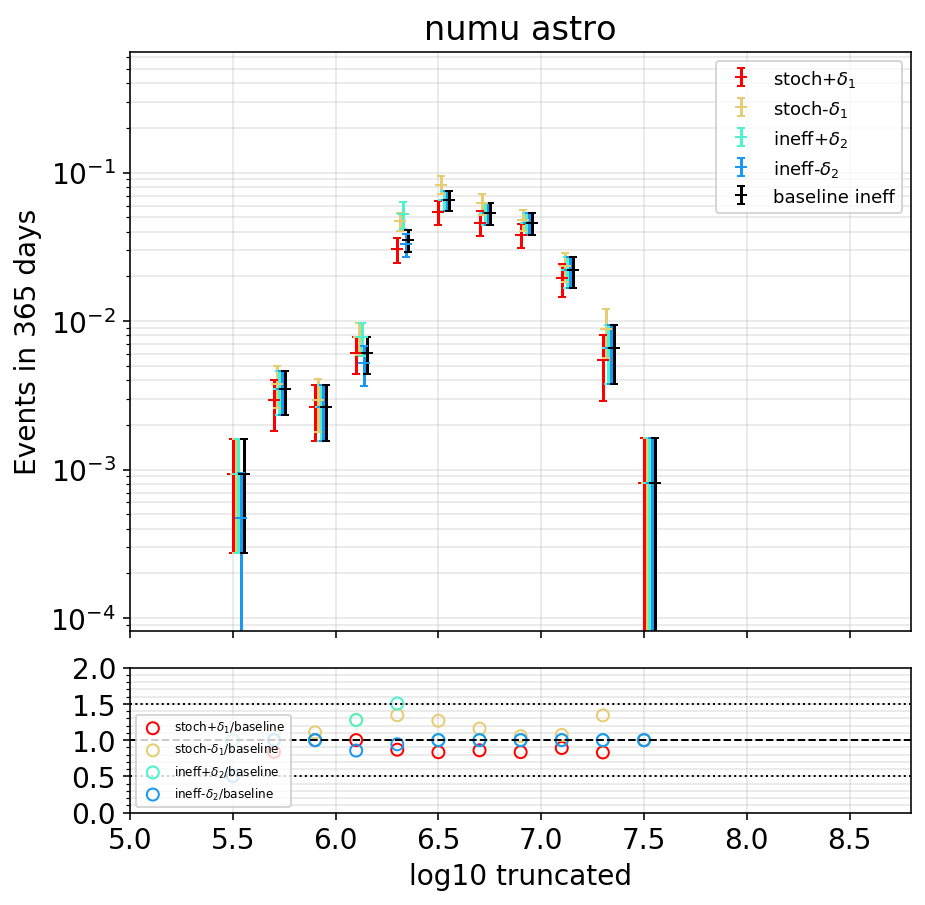

In [50]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.log10(truncated_muon_e_numu),
          weight_numu_astro,
          np.arange(5,9,0.2),
          'numu astro',
          'log10 truncated',
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


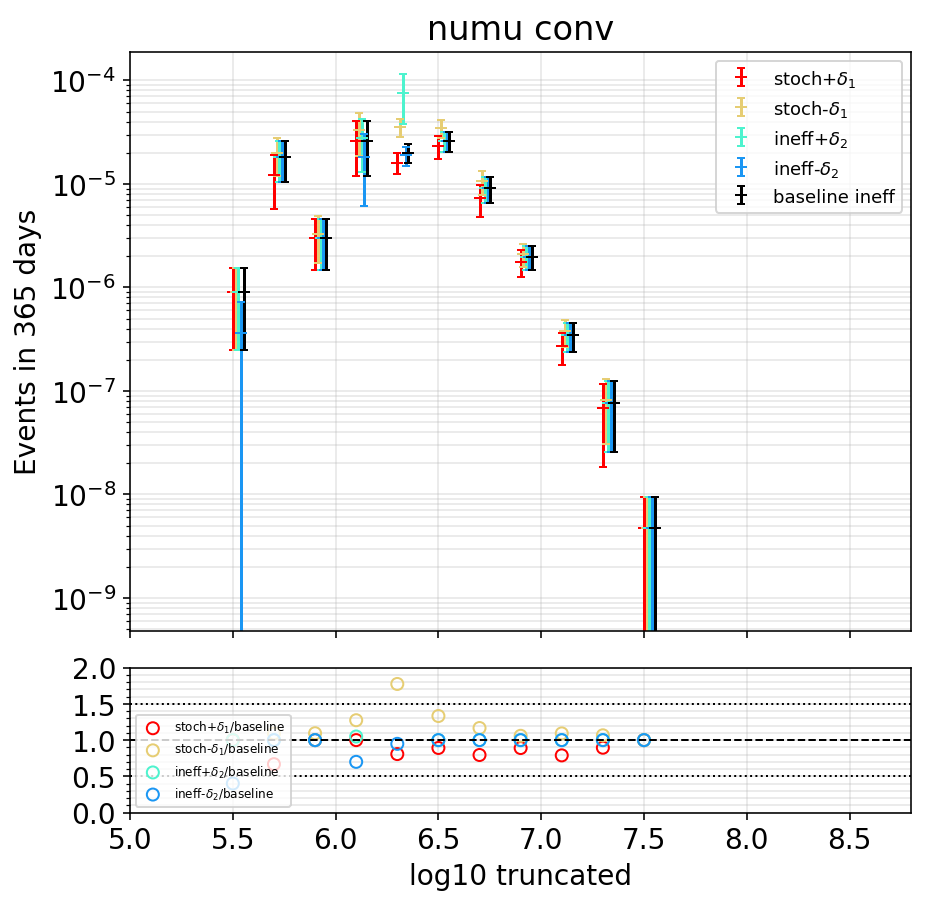

In [51]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.log10(truncated_muon_e_numu),
          weight_numu_conv,
          np.arange(5,9,0.2),
          'numu conv',
          'log10 truncated',
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


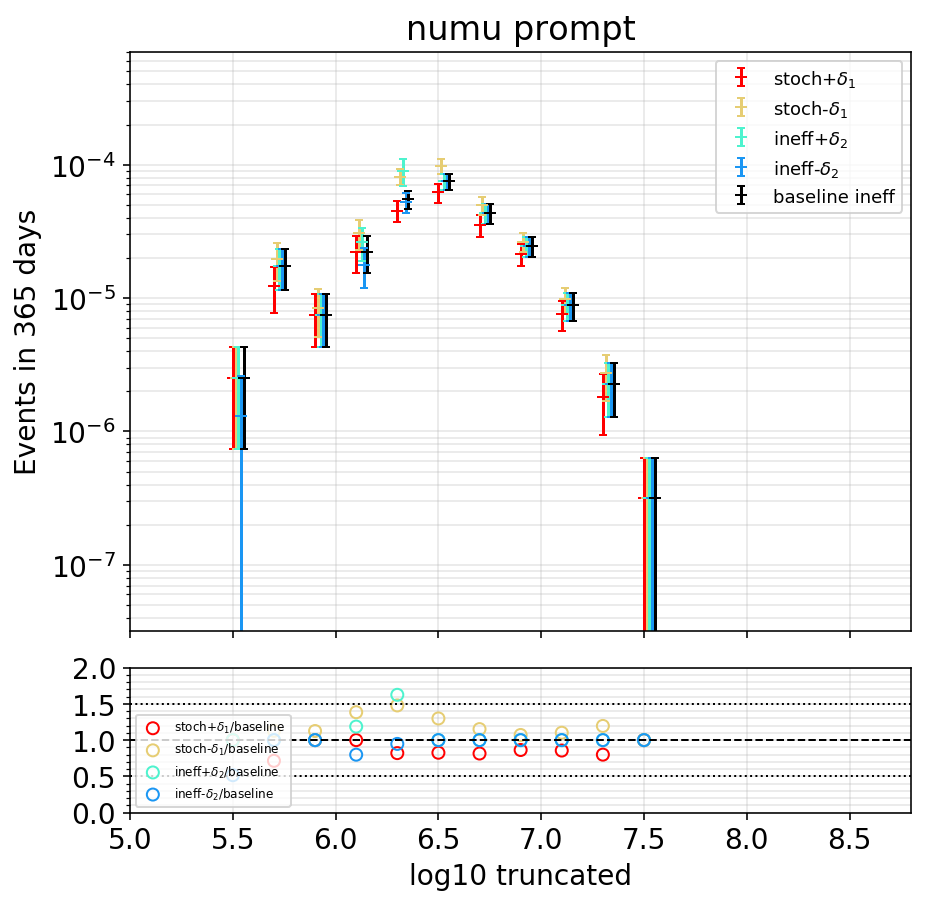

In [52]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.log10(truncated_muon_e_numu),
          weight_numu_prompt,
          np.arange(5,9,0.2),
          'numu prompt',
          'log10 truncated',
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


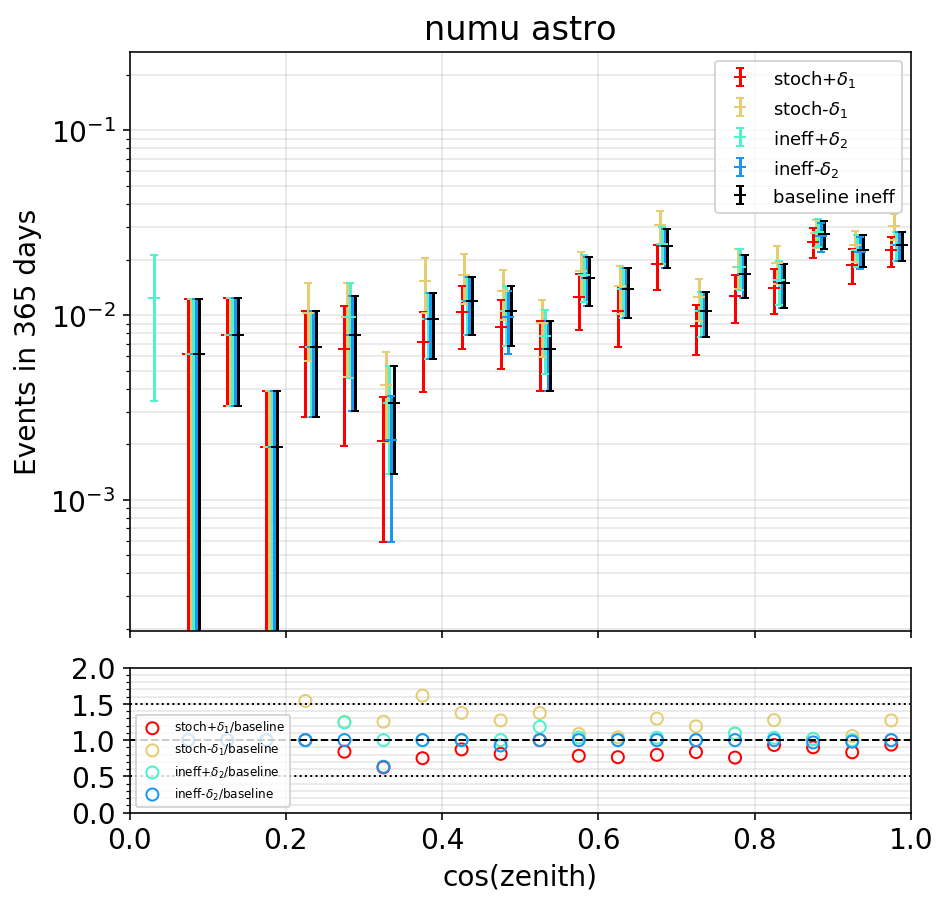

In [53]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.cos(zenith_numu),
          weight_numu_astro,
          np.arange(0,1.05,0.05),
          'numu astro',
          'cos(zenith)'
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


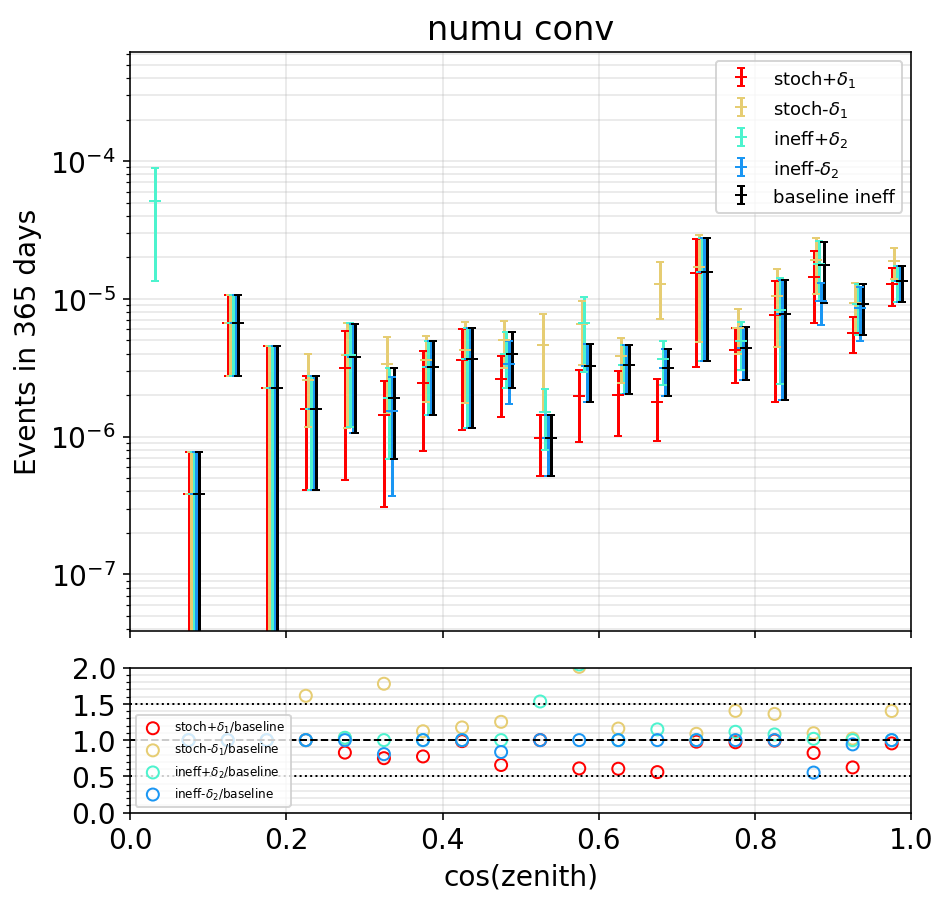

In [54]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.cos(zenith_numu),
          weight_numu_conv,
          np.arange(0,1.05,0.05),
          'numu conv',
          'cos(zenith)'
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


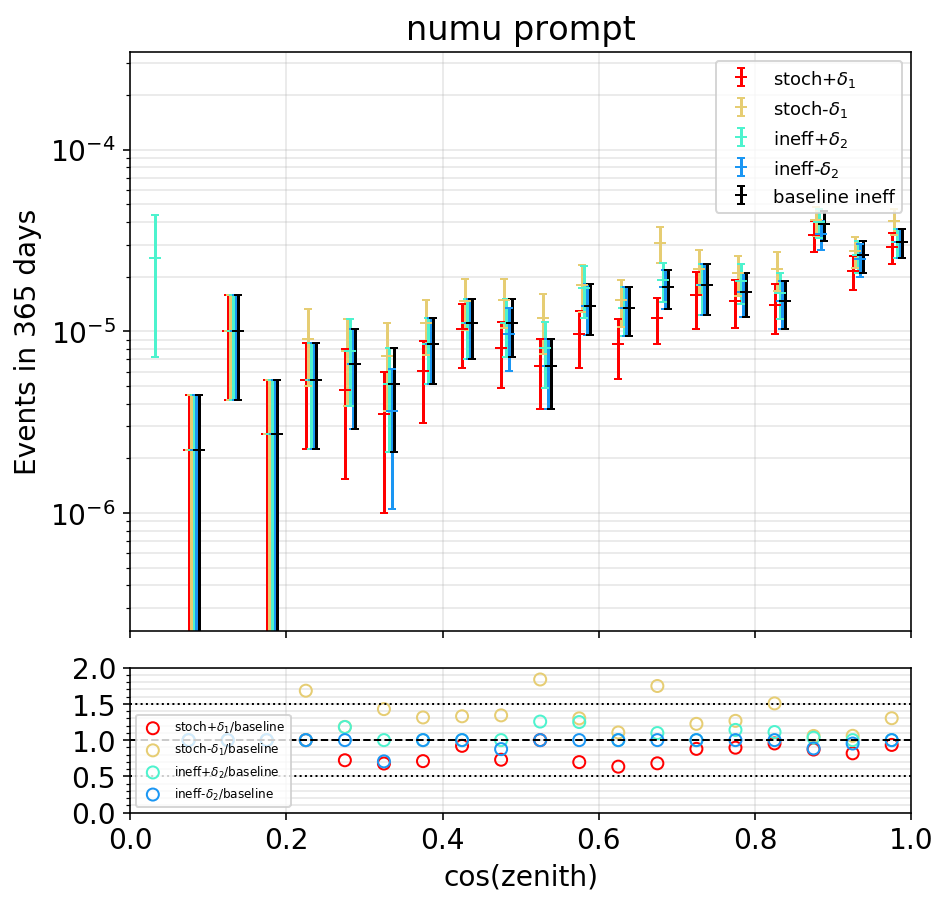

In [55]:
variation(np.log10(chi2_red_new_numu),
          ineff_numu,
          np.cos(zenith_numu),
          weight_numu_prompt,
          np.arange(0,1.05,0.05),
          'numu prompt',
          'cos(zenith)'
         )